In [1]:
import os

import pytesseract
from pytesseract import Output
import cv2

# Libraries for Visualization
from PIL import Image, ImageDraw
from IPython.display import display

import src.wordbox
from src.Task1 import task1

In [2]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

In [3]:
def debug(index):
    box = boxes[index]
    return (box.page_num, box.block_num, box.par_num, box.line_num)

def info(box):
    return str((box.text, box.left, box.top, box.width, box.height))

def gravityCenter(box):
# Compute the gravity center of `box`.
    return (box.left + box.width / 2, box.top + box.height / 2)

def isHorizontal(this, other):
# Check whether `other` is placed horizontally wrt to `this`.
    if this.top >= other.top + other.height:
        return False
    if other.top >= this.top + this.height:
        return False
    return True

def isVertical(this, other):
# Check whether `other` is placed vertically wrt to `this`.
    if this.left >= other.left + other.width:
        return False
    if other.left >= this.left + this.width:
        return False
    return True

def coordDiff(this, other, axis):
# Coordinate difference on `axis`.
    return abs(gravityCenter(this)[axis] - gravityCenter(other)[axis])

def isHCloser(this, other, that):
# Is `other` horizontally closer than `that` wrt `this`?
    return coordDiff(this, other, 0) <= coordDiff(this, that, 0) 

def isVCloser(this, other, that):
# Is `other` vertically closer than `that` wrt `this`?
    return coordDiff(this, other, 1) <= coordDiff(this, that, 1) 

def isLeft(this, other):
# Left?
    return isHorizontal(this, other) and gravityCenter(this)[0] >= gravityCenter(other)[0]

def isRight(this, other):
# Right?
    return isHorizontal(this, other) and gravityCenter(this)[0] <= gravityCenter(other)[0]

def isTop(this, other):
# Top?
    return isVertical(this, other) and gravityCenter(this)[1] >= gravityCenter(other)[1]

def isBottom(this, other):
# Bottom?
    return isVertical(this, other) and gravityCenter(this)[1] <= gravityCenter(other)[1]

# Function mapper.
mapper = {'left': {'direction_fn' : isLeft, 'closer_fn' : isHCloser},
          'right' : {'direction_fn' : isRight, 'closer_fn' : isHCloser},
          'top' : {'direction_fn' : isTop, 'closer_fn' : isVCloser},
          'bottom' : {'direction_fn' : isBottom, 'closer_fn' : isVCloser}
         }

def computeDistance(this, other):
    gc1 = gravityCenter(this)
    gc2 = gravityCenter(other)
    return ((gc1[0] - gc2[0])**2 + (gc1[1] - gc2[1])**2)**0.5

# Update the neighbors.
def update(coord, this, other):
    for key in coord.keys():
        if mapper[key]['direction_fn'](this, other):
            if (coord[key] is None) or (mapper[key]['closer_fn'](this, other, coord[key]['which'])):
                coord[key] = {'which' : other, 'distance' : computeDistance(this, other)}

# Print the graph.
# TODO: visualize graph
# print('\n'.join([str(elem) for elem in boxes]))

In [4]:
# Construct the graph.
def construct_graph(filepath):
    boxes = task1('img/test.jpg', 'output/test.txt')
    graph = {}
    for i, box1 in enumerate(boxes):
        coord = {'left' : None, 'right' : None, 'top' : None, 'bottom' : None}
        for j, box2 in enumerate(boxes):
            if i == j:
                continue
            update(coord, box1, box2)
        # Set the neighbors.
        box1.set_neighs(left=coord['left'], right=coord['right'], top=coord['top'], bottom=coord['bottom'])

    return boxes

In [5]:
def annotate_image(filepath, boxes):
# Visualize the Box and Neighbours using PIL
    kWidth = 2
    kBoxColor = (0, 0, 255, 255)
    with Image.open(filepath).convert('RGBA') as img:
        draw = ImageDraw.Draw(img)
    
        for box in boxes:
            top, bottom, left, right = box.top, box.top + box.height, box.left, box.left + box.width
            # Top, Bottom, Left, Right Lines
            draw.line((left, top, right, top), width=kWidth, fill=kBoxColor)
            draw.line((left, bottom, right, bottom), width=kWidth, fill=kBoxColor)
            draw.line((left, top, left, bottom), width=kWidth, fill=kBoxColor)
            draw.line((right, top, right, bottom), width=kWidth, fill=kBoxColor)

            for name, neighbour in box.neighs.items():
                if neighbour is not None:
                    neigh = neighbour['which']
                    if name == 'top':
                        boxPos = (box.left + box.width / 2, box.top)
                        neighPos = (neigh.left + neigh.width / 2, neigh.top + neigh.height)
                    elif name == 'bottom':
                        boxPos = (box.left + box.width / 2, box.top + box.height)
                        neighPos = (neigh.left + neigh.width / 2, neigh.top)
                    elif name == 'left':
                        boxPos = (box.left, box.top + box.height / 2)
                        neighPos = (neigh.left + neigh.width, neigh.top + neigh.height / 2)
                    elif name == 'right':
                        boxPos = (box.left + box.width, box.top + box.height / 2)
                        neighPos = (neigh.left, neigh.top + neigh.height / 2)
                    # Draw Line between Gravity Center of Box and Neighbour
                    draw.line(boxPos + neighPos, width=1, fill=(0, 255, 0, 255))
        display(img)

Process: img/test.jpg


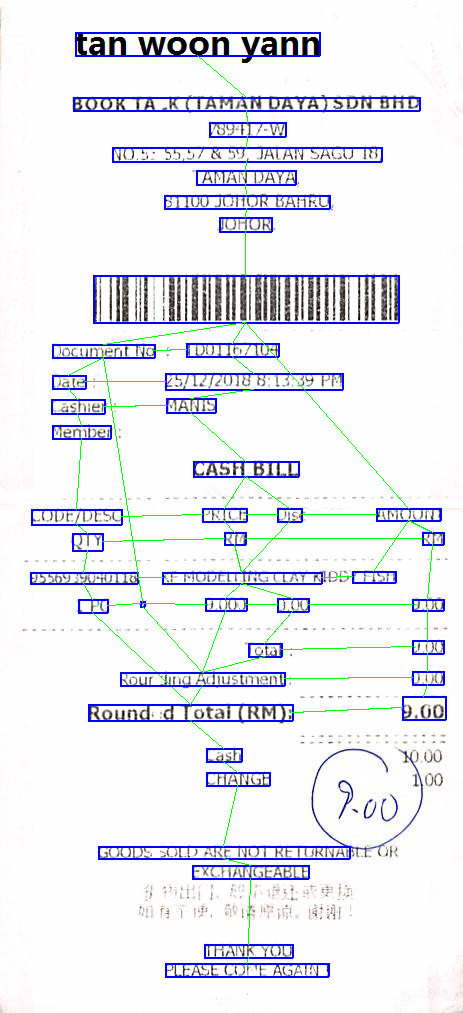

In [6]:
def construct_annotated_graph(filepath):
# Construct the Graph and Visualize it
    boxes = construct_graph(filepath)
    annotate_image(filepath, boxes)

construct_annotated_graph('./img/test.jpg')